### Import Package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df_cleaned = pd.read_csv('data/loan_cleaned.csv')
df_eda = df_cleaned.copy()
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          466285 non-null  int64  
 1   loan_amnt                   466285 non-null  int64  
 2   funded_amnt                 466285 non-null  int64  
 3   funded_amnt_inv             466285 non-null  float64
 4   term                        466285 non-null  object 
 5   int_rate                    466285 non-null  float64
 6   installment                 466285 non-null  float64
 7   grade                       466285 non-null  object 
 8   emp_length                  466285 non-null  int64  
 9   home_ownership              466285 non-null  object 
 10  annual_inc                  466285 non-null  float64
 11  verification_status         466285 non-null  object 
 12  loan_status                 466285 non-null  int64  
 13  pymnt_plan    

<AxesSubplot:>

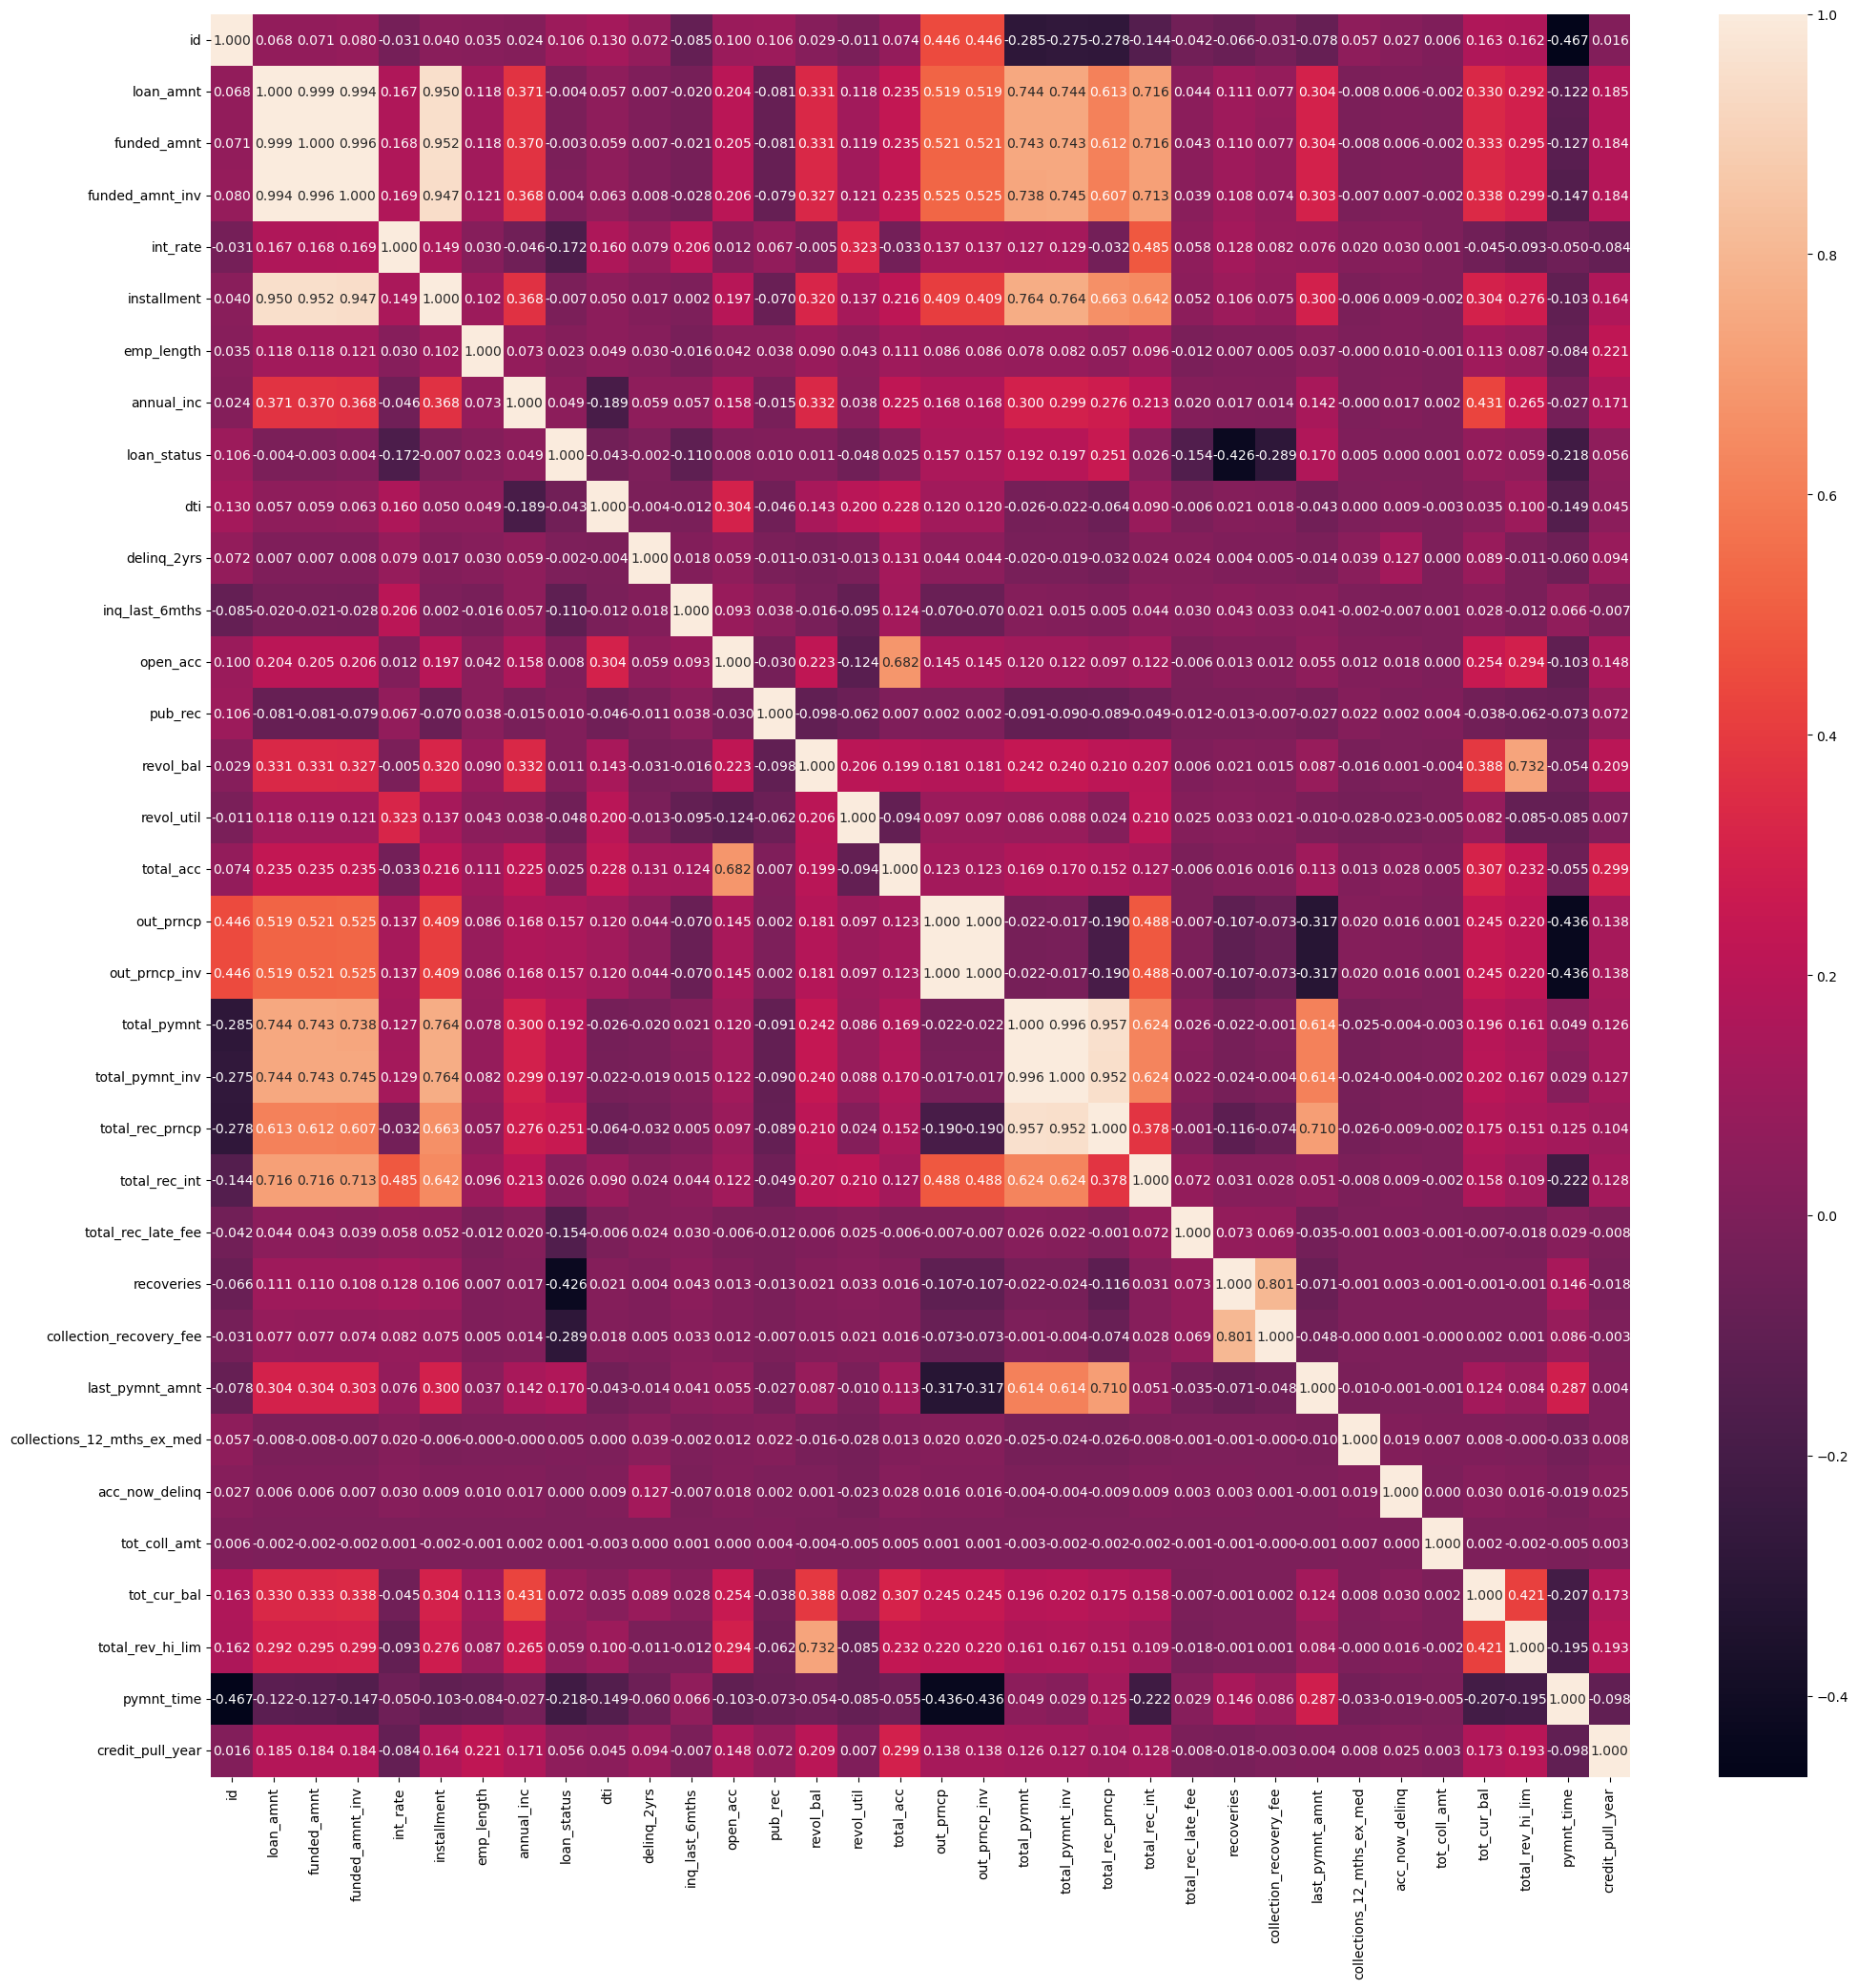

In [4]:
plt.figure(figsize=(24,24))
sns.heatmap(df_eda.corr(),annot=True,fmt='.3f')

* It appears that there are several independent features that are highly correlated with each other so that it can lead to biased results if left unchecked.
* Decided to remove features that have a correlation of more than 0.8

#### Univariate Analysis

In [5]:
num = df_eda.select_dtypes(include='number').columns
cat = df_eda.select_dtypes(include='object').columns

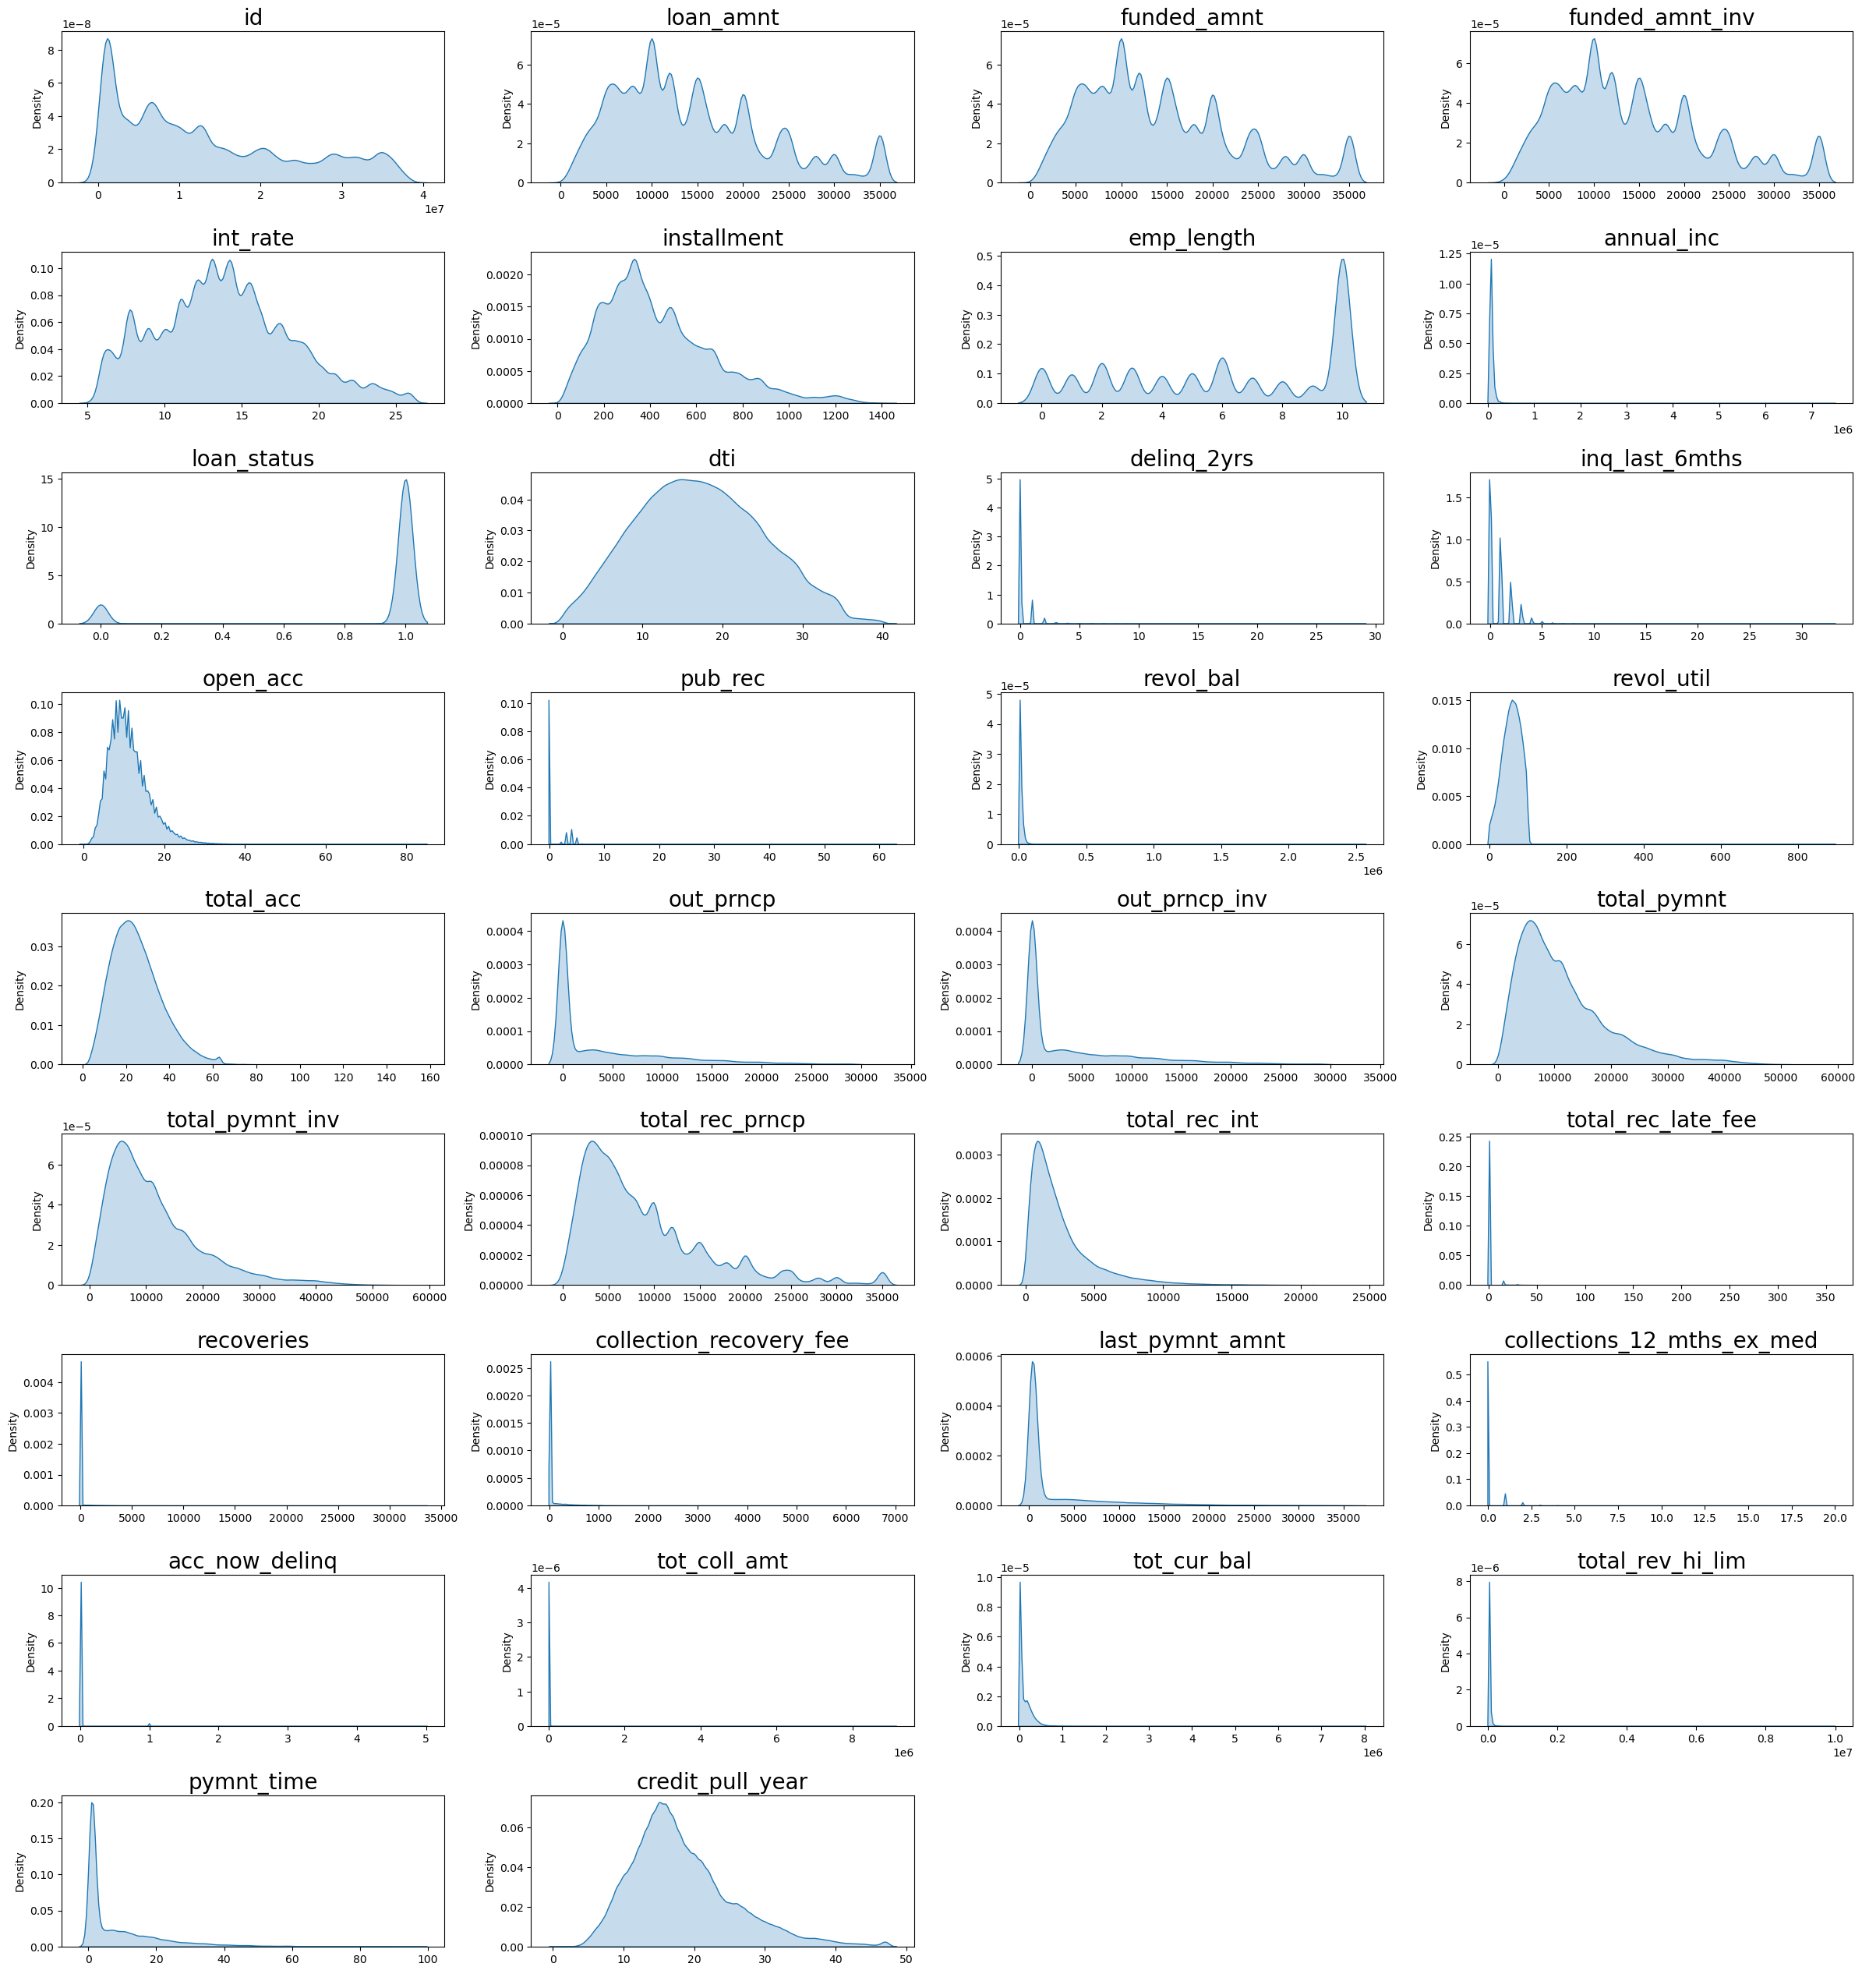

In [6]:
plt.figure(figsize=(24,28))
for i in range(0,len(num)):
    plt.subplot(10,4,i+1)
    sns.kdeplot(x=df_eda[num[i]], palette='viridis', shade=True)
    plt.title(num[i], fontsize=20)
    plt.xlabel(' ')
    plt.tight_layout()

* The majority of numerical features are not normally distributed

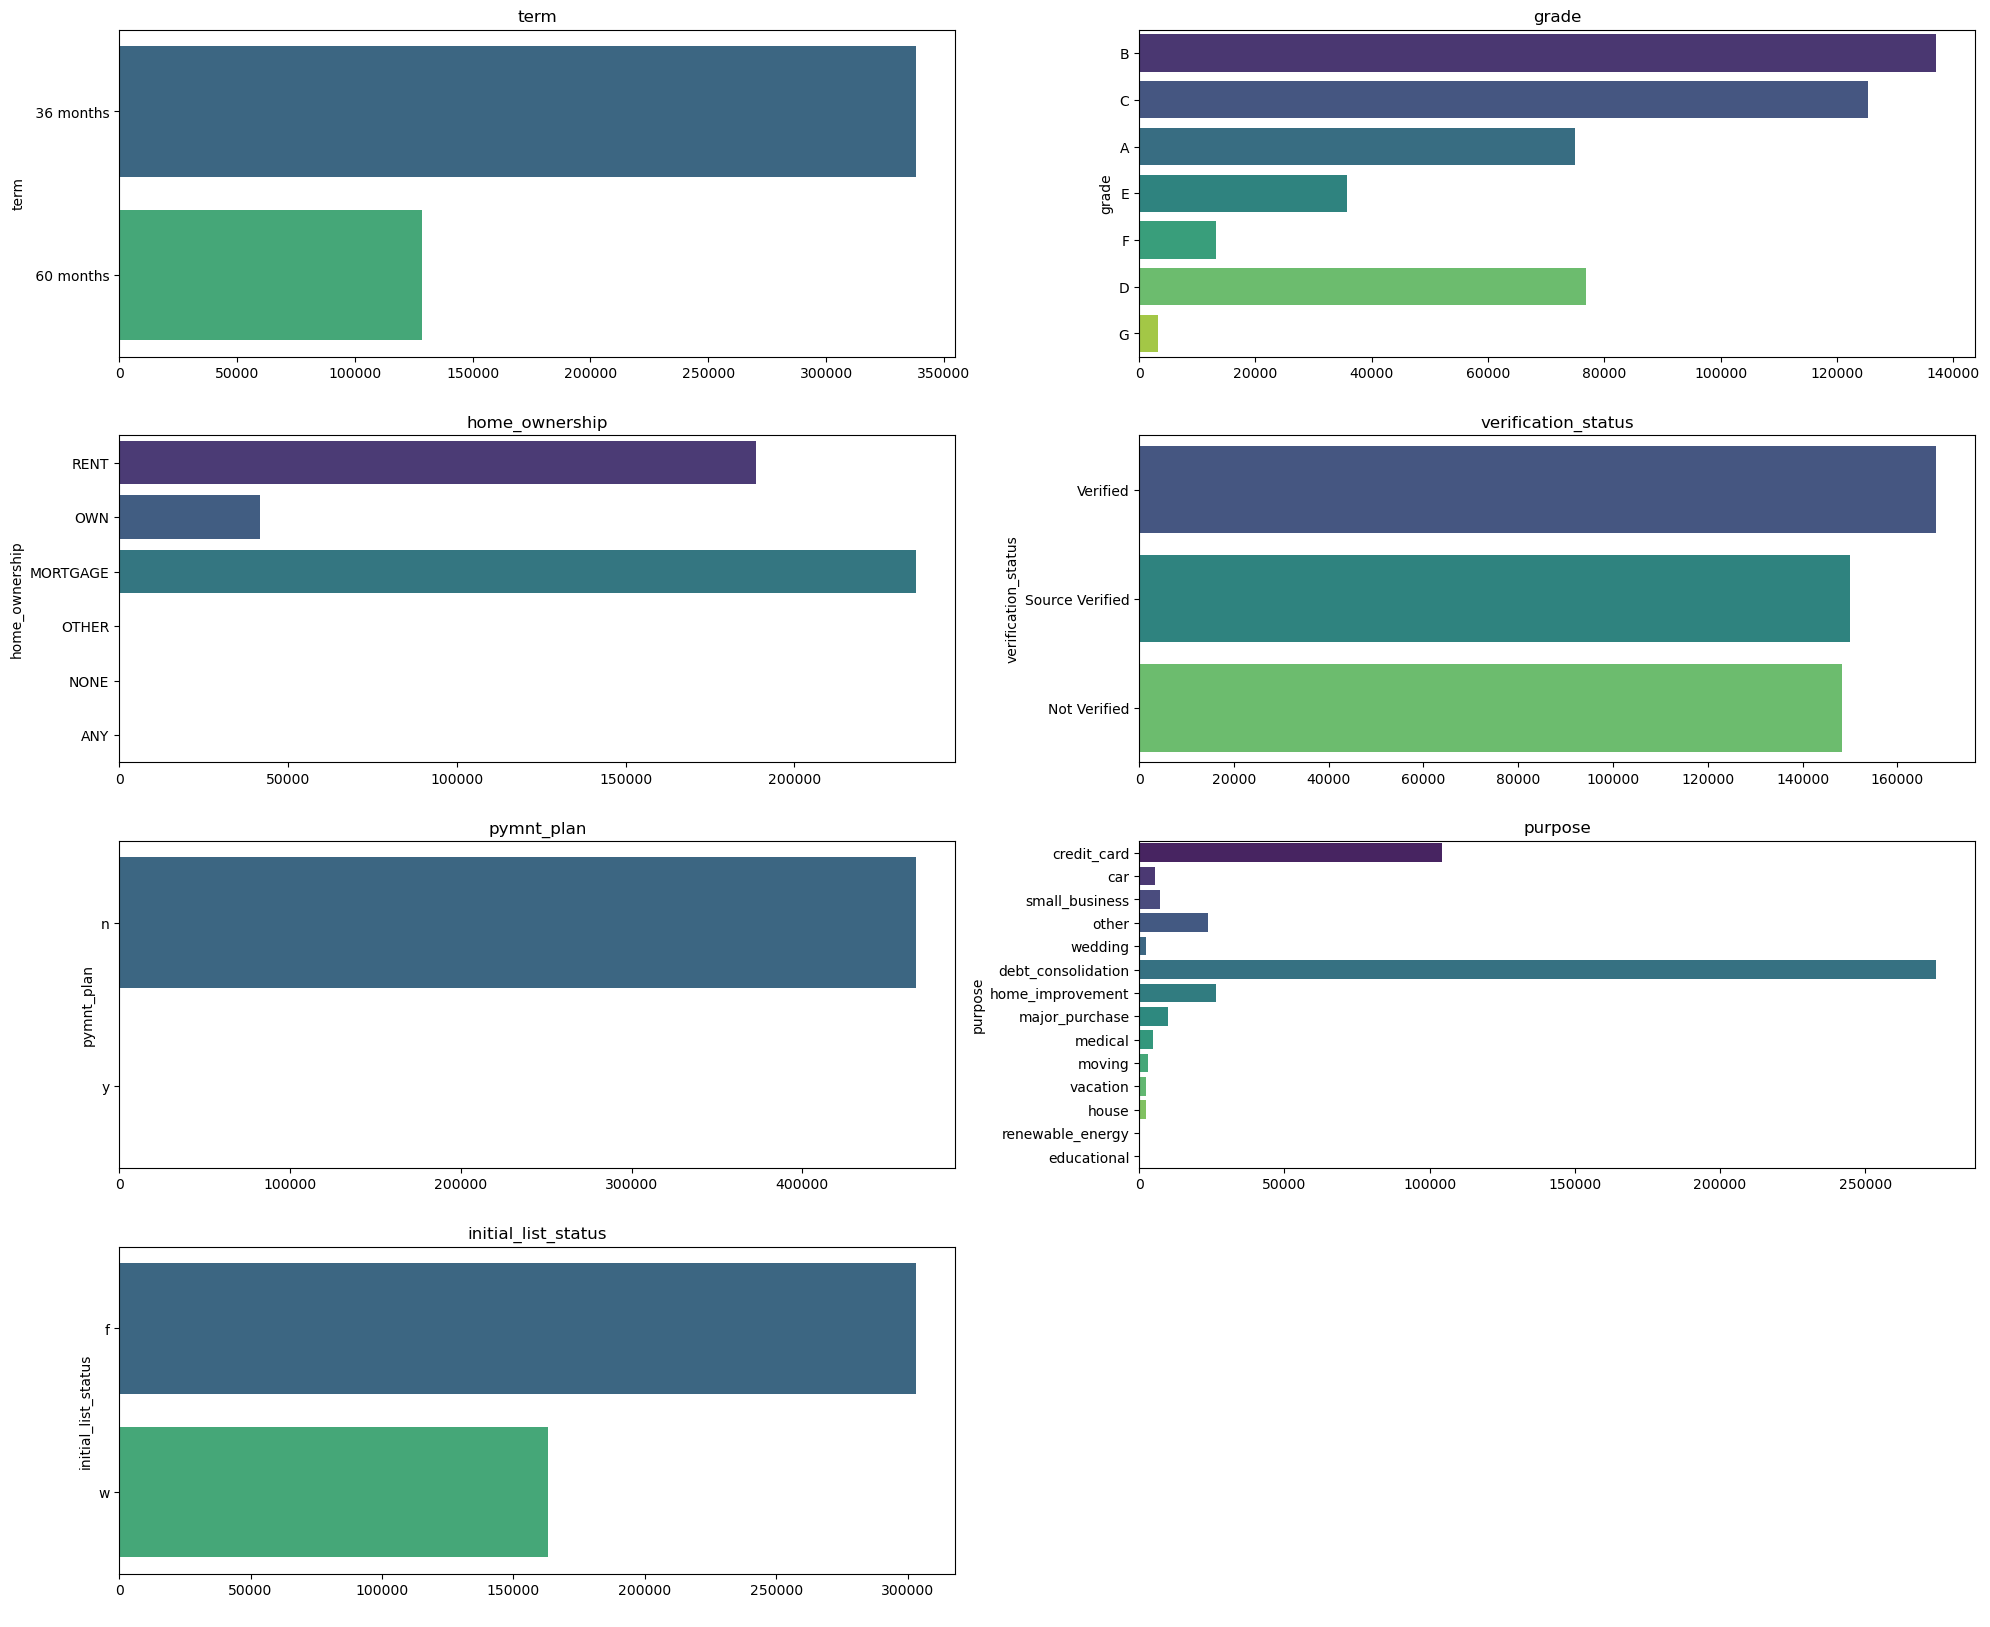

In [7]:
plt.figure(figsize=(20,20))
for i in range(0,len(cat)):
    plt.subplot(5,2,i+1)
    sns.countplot(y=df_eda[cat[i]], orient = 'h',palette='viridis')
    plt.title(cat[i])
    plt.xlabel(' ')
    plt.tight_layout()

#### Bivariate Analysis

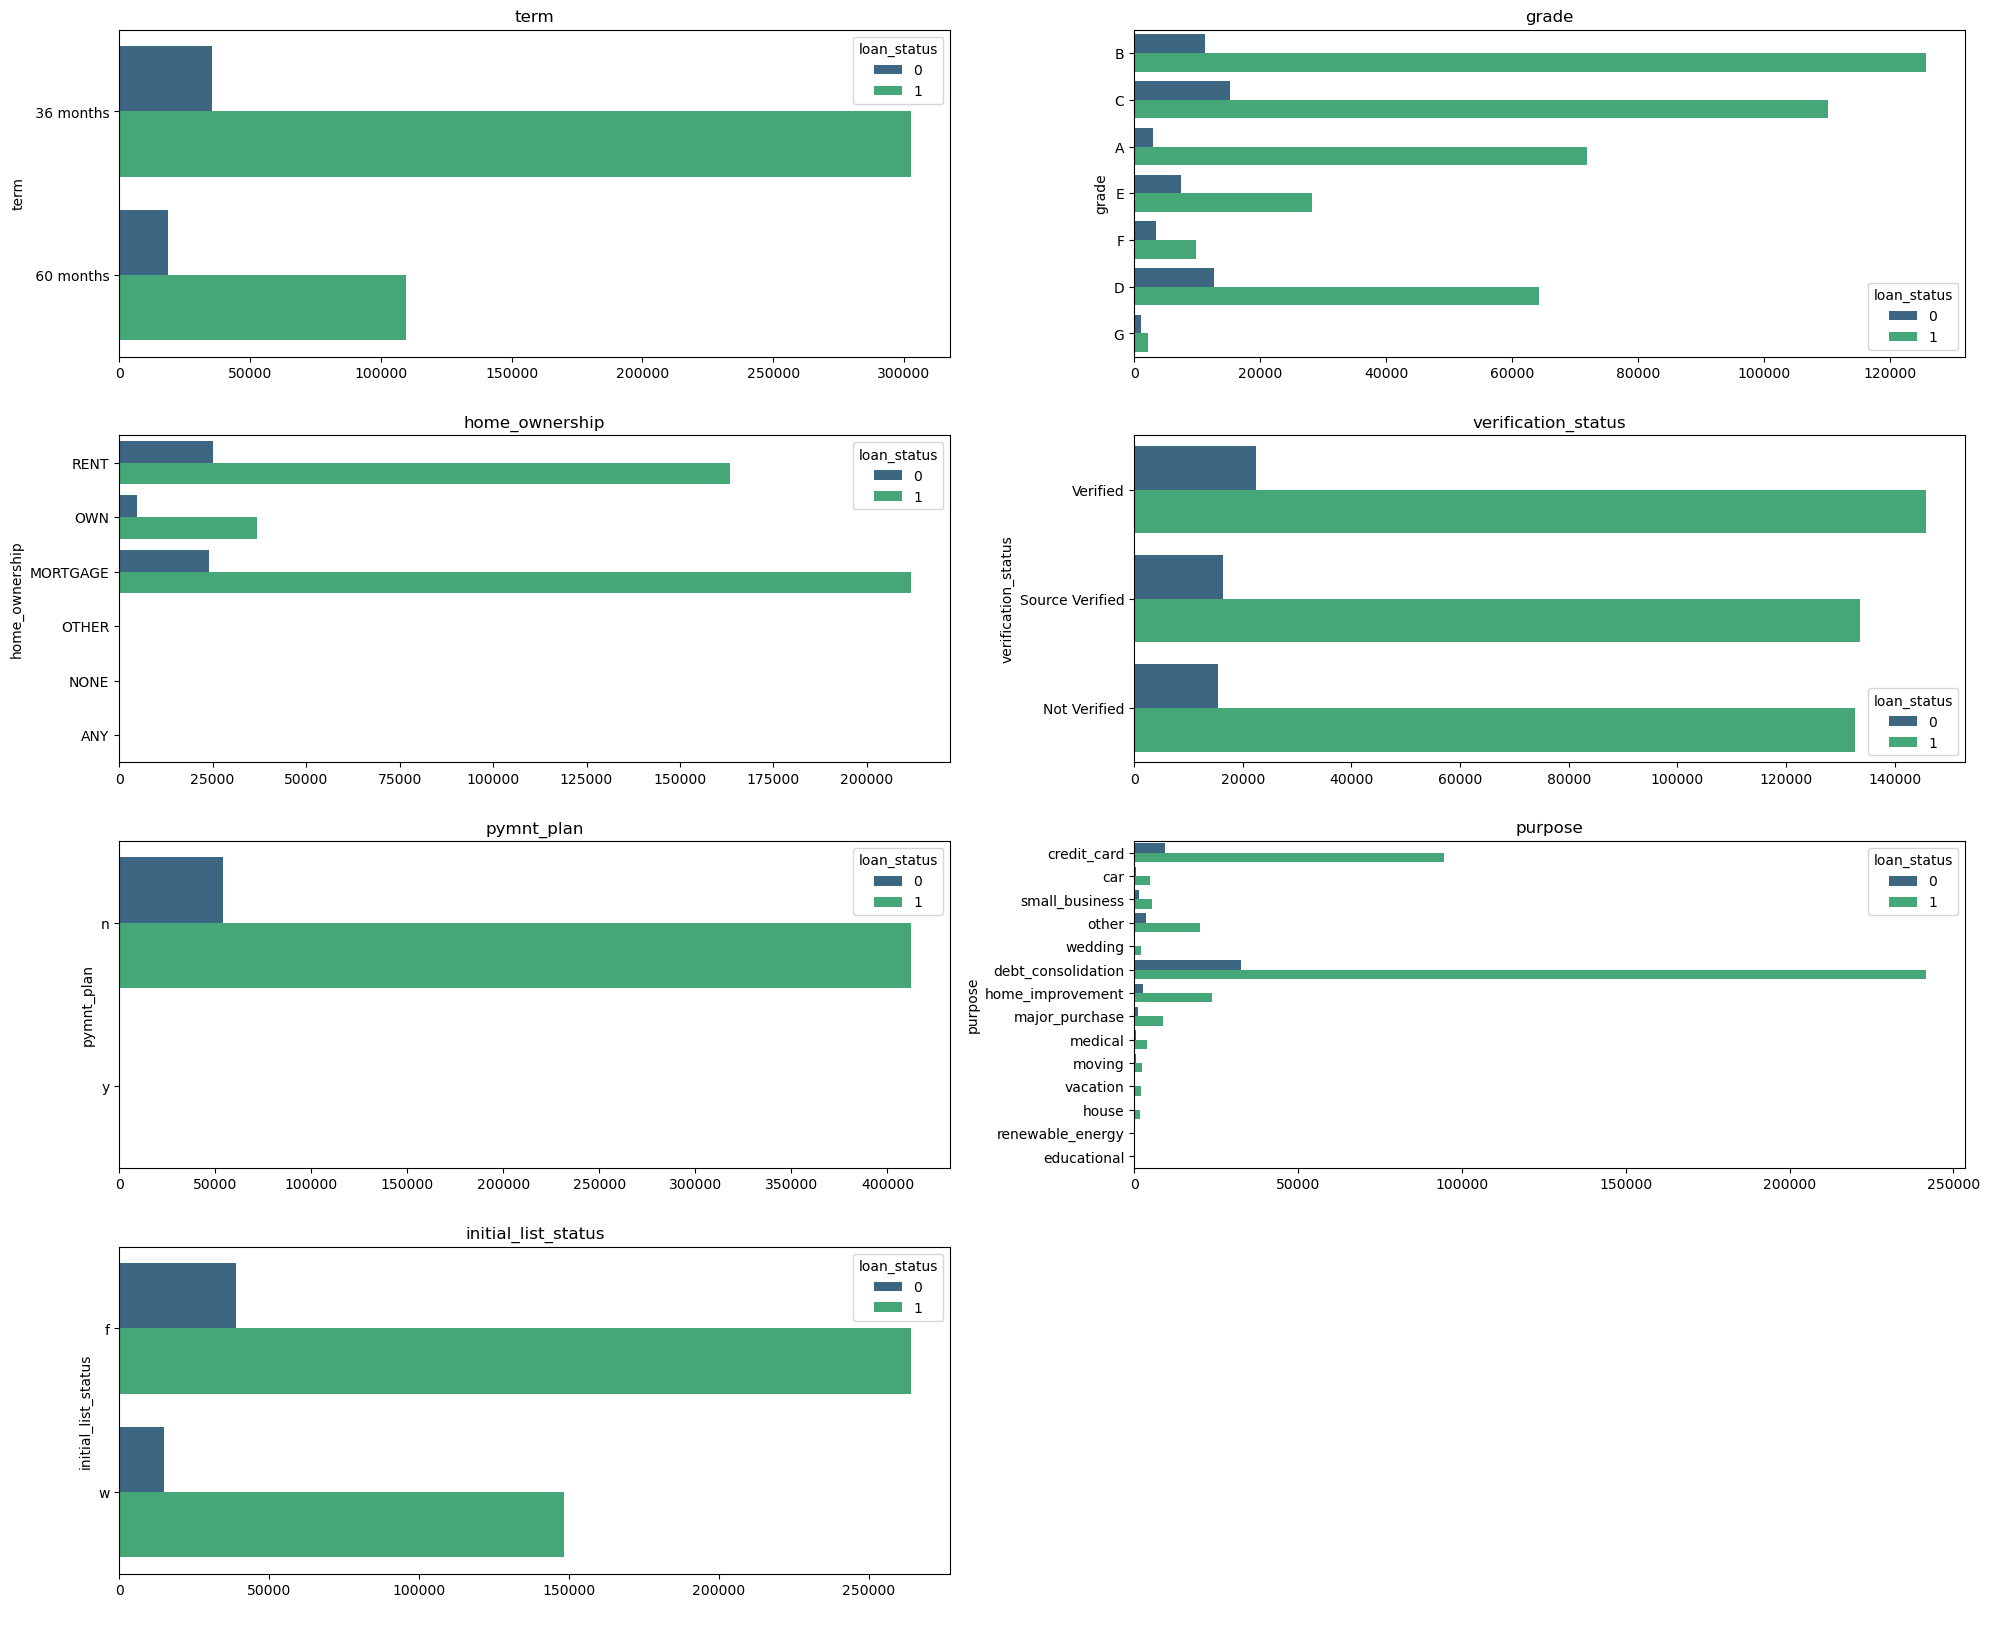

In [8]:
plt.figure(figsize=(20,20))
for i in range(0,len(cat)):
    plt.subplot(5,2,i+1)
    sns.countplot(y=df_eda[cat[i]], palette='viridis', hue=df_cleaned['loan_status'])
    plt.title(cat[i])
    plt.xlabel(' ')
    plt.tight_layout()

#### Feature Engineering

In [9]:
# Create Function for Weight of Evidence and Invormation Value

def woe(df, feature_name):
    feature_name = df.groupby(feature_name).agg(num_observation=('loan_status','count'),good_loan_prob=('loan_status','mean')).reset_index()
    feature_name['grade_proportion'] = feature_name['num_observation']/feature_name['num_observation'].sum()
    feature_name['num_good_loan'] = feature_name['grade_proportion'] * feature_name['num_observation']
    feature_name['num_bad_loan'] = (1-feature_name['grade_proportion']) * feature_name['num_observation']
    feature_name['good_loan_prop'] = feature_name['num_good_loan'] / feature_name['num_good_loan'].sum()
    feature_name['bad_loan_prop'] = feature_name['num_bad_loan'] / feature_name['num_bad_loan'].sum()
    feature_name['weight_of_evidence'] = np.log(feature_name['good_loan_prop'] / feature_name['bad_loan_prop'])
    feature_name = feature_name.sort_values('weight_of_evidence').reset_index(drop=True)
    feature_name['information_value'] = (feature_name['good_loan_prop']-feature_name['bad_loan_prop']) * feature_name['weight_of_evidence']
    feature_name['information_value'] = feature_name['information_value'].sum()

    #Show
    feature_name = feature_name.drop(['grade_proportion','num_good_loan','num_bad_loan','good_loan_prop','bad_loan_prop'],axis = 1)
    return feature_name

In [10]:
def dist(feature):
    plt.figure(figsize=(4,2))
    sns.violinplot(df_cleaned[feature],color='blue')
    print('number of unique values :',df_cleaned[feature].nunique())
    print('Distribution :')
    print(df_cleaned[feature].describe().T)

##### WOE Grade

In [11]:
woe(df_eda,'grade')

,grade,num_observation,good_loan_prob,weight_of_evidence,information_value
0,G,3322,0.679711,-3.660567,0.292639
1,F,13229,0.741401,-2.257091,0.292639
2,E,35757,0.789775,-1.211753,0.292639
3,A,74867,0.959328,-0.377550,0.292639
4,D,76888,0.835787,-0.345737,0.292639
5,C,125293,0.878493,0.275309,0.292639
6,B,136929,0.917643,0.398836,0.292639


In [12]:
woe(df_eda,'home_ownership')

,home_ownership,num_observation,good_loan_prob,weight_of_evidence,information_value
0,ANY,1,1.000000,-12.759563,0.31222
1,NONE,50,0.760000,-8.847435,0.31222
2,OTHER,182,0.642857,-7.555168,0.31222
3,OWN,41704,0.885359,-2.027518,0.31222
4,RENT,188473,0.866501,-0.095002,0.31222
5,MORTGAGE,235875,0.897594,0.316429,0.31222


In [13]:
woe(df_eda,'verification_status')

,verification_status,num_observation,good_loan_prob,weight_of_evidence,information_value
0,Not Verified,148237,0.895262,-0.075220,0.007663
1,Source Verified,149993,0.891342,-0.057908,0.007663
2,Verified,168055,0.867008,0.114596,0.007663


In [14]:
woe(df_eda,'purpose')

,purpose,num_observation,good_loan_prob,weight_of_evidence,information_value
0,renewable_energy,351,0.840456,-6.796087,1.409257
1,educational,422,0.637441,-6.611715,1.409257
2,house,2269,0.843543,-4.925653,1.409257
3,wedding,2343,0.860009,-4.893401,1.409257
4,vacation,2487,0.872135,-4.833445,1.409257
5,moving,2994,0.834335,-4.646819,1.409257
6,medical,4602,0.856584,-4.213461,1.409257
7,car,5397,0.900130,-4.052385,1.409257
8,small_business,7013,0.766862,-3.786951,1.409257
9,major_purchase,9828,0.891941,-3.443333,1.409257


In [15]:
woe(df_eda,'initial_list_status')

,initial_list_status,num_observation,good_loan_prob,weight_of_evidence,information_value
0,w,163280,0.907741,-0.798355,0.340013
1,f,303005,0.870926,0.438211,0.340013


In [16]:
woe(df_eda,'term')

,term,num_observation,good_loan_prob,weight_of_evidence,information_value
0,60 months,128332,0.853458,-1.378129,0.72423
1,36 months,337953,0.895346,0.558444,0.72423


#### WOE Numeric

C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 1352
Distribution :
count    466285.000000
mean      14317.277577
std        8286.509164
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64


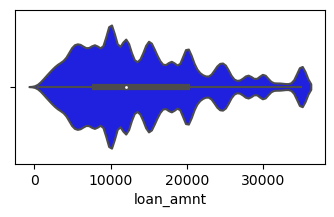

In [17]:
dist('loan_amnt')

In [18]:
df_eda['loan_amnt_woe'] = pd.cut(df_eda['loan_amnt'],10)
woe(df_eda,'loan_amnt_woe')

,loan_amnt_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(28100.0, 31550.0]",13389,0.871088,-1.618217,0.249994
1,"(31550.0, 35000.0]",21517,0.878840,-1.125698,0.249994
2,"(21200.0, 24650.0]",25467,0.882789,-0.948237,0.249994
3,"(24650.0, 28100.0]",26705,0.882232,-0.897957,0.249994
4,"(465.5, 3950.0]",27901,0.877280,-0.851421,0.249994
5,"(17750.0, 21200.0]",58167,0.884264,-0.045227,0.249994
6,"(14300.0, 17750.0]",60751,0.882685,0.004590,0.249994
7,"(10850.0, 14300.0]",65080,0.889505,0.084156,0.249994
8,"(3950.0, 7400.0]",75702,0.886608,0.262176,0.249994
9,"(7400.0, 10850.0]",91606,0.883708,0.494439,0.249994


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 506
Distribution :
count    466285.000000
mean         13.829236
std           4.357587
min           5.420000
25%          10.990000
50%          13.660000
75%          16.490000
max          26.060000
Name: int_rate, dtype: float64


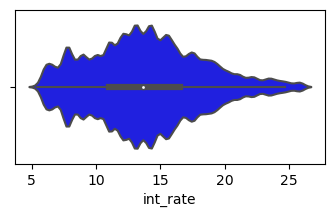

In [19]:
dist('int_rate')

In [20]:
df_eda['int_rate_woe'] = pd.cut(df_eda['int_rate'],10)
woe(df_eda,'int_rate_woe')

,int_rate_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(23.996, 26.06]",8846,0.758761,-2.104911,0.273615
1,"(21.932, 23.996]",14343,0.763787,-1.609524,0.273615
2,"(19.868, 21.932]",19782,0.797341,-1.275906,0.273615
3,"(5.399, 7.484]",27568,0.973919,-0.926431,0.273615
4,"(17.804, 19.868]",38003,0.815436,-0.581349,0.273615
5,"(7.484, 9.548]",56410,0.952987,-0.142438,0.273615
6,"(9.548, 11.612]",58827,0.922298,-0.094569,0.273615
7,"(15.74, 17.804]",60358,0.839259,-0.065112,0.273615
8,"(13.676, 15.74]",87615,0.875478,0.377055,0.273615
9,"(11.612, 13.676]",94533,0.904002,0.471490,0.273615


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 31901
Distribution :
count    4.662850e+05
mean     7.327729e+04
std      5.496334e+04
min      1.896000e+03
25%      4.500000e+04
50%      6.300000e+04
75%      8.895300e+04
max      7.500000e+06
Name: annual_inc, dtype: float64


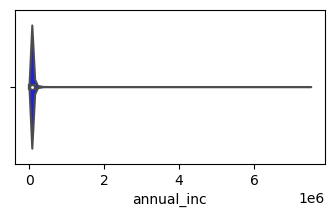

In [21]:
dist('annual_inc')

In [22]:
df_cleaned['annual_inc_fc'] = np.where((df_cleaned['annual_inc']>=0)&(df_cleaned['annual_inc']<=200000),'low_income',
                               np.where((df_cleaned['annual_inc']>200000)&(df_cleaned['annual_inc']<=1500000),'med_income','high_income'))
woe(df_cleaned,'annual_inc_fc')

,annual_inc_fc,num_observation,good_loan_prob,weight_of_evidence,information_value
0,high_income,19,1.000000,-13.488976,4.080337
1,med_income,7781,0.919548,-7.457187,4.080337
2,low_income,458485,0.883207,0.692901,4.080337


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 3997
Distribution :
count    466285.000000
mean         17.218758
std           7.851121
min           0.000000
25%          11.360000
50%          16.870000
75%          22.780000
max          39.990000
Name: dti, dtype: float64


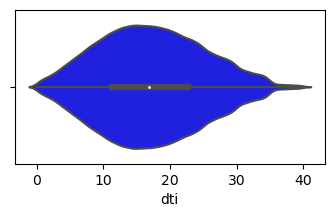

In [23]:
dist('dti')

In [24]:
df_eda['dti_woe'] = pd.cut(df_eda['dti'],10)
woe(df_eda,'dti_woe')

,dti_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(35.991, 39.99]",2753,0.875772,-3.292330,0.215744
1,"(31.992, 35.991]",13654,0.862604,-1.667191,0.215744
2,"(-0.04, 3.999]",16728,0.891619,-1.457325,0.215744
3,"(27.993, 31.992]",30288,0.861826,-0.833030,0.215744
4,"(3.999, 7.998]",42962,0.905544,-0.453966,0.215744
5,"(23.994, 27.993]",50073,0.865037,-0.283859,0.215744
6,"(7.998, 11.997]",69311,0.900853,0.088587,0.215744
7,"(19.995, 23.994]",71058,0.869726,0.117890,0.215744
8,"(15.996, 19.995]",84089,0.881435,0.319796,0.215744
9,"(11.997, 15.996]",85369,0.894072,0.338258,0.215744


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 24
Distribution :
count    466285.000000
mean          0.284661
std           0.797343
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: delinq_2yrs, dtype: float64


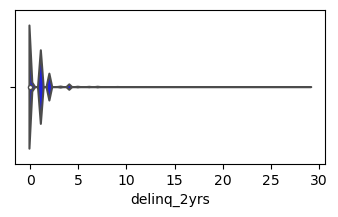

In [25]:
dist('delinq_2yrs')

In [26]:
df_eda['delinq_2yrs_woe'] = pd.cut(df_eda['delinq_2yrs'],5)
woe(df_eda,'delinq_2yrs_woe')

,delinq_2yrs_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(23.2, 29.0]",2,1.000000,-17.422435,5.899539
1,"(17.4, 23.2]",13,0.846154,-15.550609,5.899539
2,"(11.6, 17.4]",86,0.767442,-13.661055,5.899539
3,"(5.8, 11.6]",1369,0.880205,-10.890811,5.899539
4,"(-0.029, 5.8]",464815,0.883851,0.693343,5.899539


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 28
Distribution :
count    466285.000000
mean          0.804695
std           1.091583
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          33.000000
Name: inq_last_6mths, dtype: float64


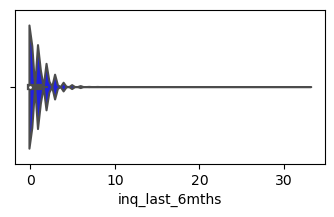

In [27]:
dist('inq_last_6mths')

In [28]:
df_eda['inq_last_6mths_woe'] = pd.cut(df_eda['inq_last_6mths'],10)
woe(df_eda,'inq_last_6mths_woe')

,inq_last_6mths_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(19.8, 23.1]",1,0.000000,-16.022424,3.763579
1,"(26.4, 29.7]",2,0.000000,-15.329275,3.763579
2,"(23.1, 26.4]",3,0.000000,-14.923808,3.763579
3,"(29.7, 33.0]",3,0.000000,-14.923808,3.763579
4,"(16.5, 19.8]",8,0.000000,-13.942968,3.763579
5,"(13.2, 16.5]",18,0.000000,-13.132016,3.763579
6,"(9.9, 13.2]",60,0.000000,-11.927953,3.763579
7,"(6.6, 9.9]",367,0.147139,-10.116277,3.763579
8,"(3.3, 6.6]",11197,0.737162,-6.674719,3.763579
9,"(-0.033, 3.3]",454626,0.888209,0.693523,3.763579


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 62
Distribution :
count    466285.000000
mean         11.186995
std           4.987380
min           0.000000
25%           8.000000
50%          10.000000
75%          14.000000
max          84.000000
Name: open_acc, dtype: float64


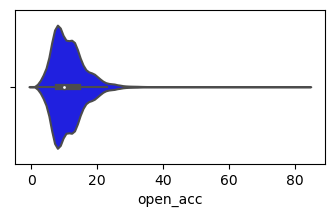

In [29]:
dist('open_acc')

In [30]:
df_eda['open_acc_woe'] = pd.cut(df_eda['open_acc'],10)
woe(df_eda,'open_acc_woe')

,open_acc_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(67.2, 75.6]",1,1.000000,-12.699435,0.523715
1,"(58.8, 67.2]",2,1.000000,-12.006286,0.523715
2,"(75.6, 84.0]",3,0.333333,-11.600819,0.523715
3,"(50.4, 58.8]",20,1.000000,-9.703662,0.523715
4,"(42.0, 50.4]",81,0.901235,-8.304815,0.523715
5,"(33.6, 42.0]",817,0.884945,-5.992045,0.523715
6,"(25.2, 33.6]",5131,0.890275,-4.145317,0.523715
7,"(16.8, 25.2]",56491,0.886601,-1.628458,0.523715
8,"(-0.084, 8.4]",151903,0.881701,-0.374252,0.523715
9,"(8.4, 16.8]",251836,0.884326,0.513821,0.523715


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 26
Distribution :
count    466285.000000
mean          0.160554
std           0.510848
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          63.000000
Name: pub_rec, dtype: float64


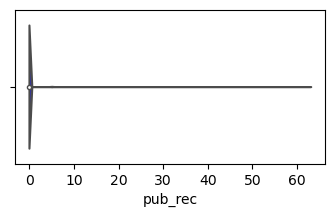

In [31]:
dist('pub_rec')

In [32]:
df_eda['pub_rec'].value_counts()

0.0     404922
1.0      53051
2.0       5624
3.0       1611
4.0        520
5.0        276
6.0        136
7.0         62
8.0         29
9.0         16
10.0        13
11.0         8
12.0         2
18.0         2
13.0         2
40.0         1
34.0         1
21.0         1
63.0         1
54.0         1
14.0         1
15.0         1
16.0         1
19.0         1
49.0         1
17.0         1
Name: pub_rec, dtype: int64

In [33]:
df_eda['pub_rec_woe'] = np.where(df_eda['pub_rec'] >= 1, 1, 0)
woe(df_eda, 'pub_rec_woe')

,pub_rec_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,1,61363,0.890667,-3.103333,1.802167
1,0,404922,0.882780,0.670442,1.802167


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 58142
Distribution :
count    4.662850e+05
mean     1.623020e+04
std      2.067625e+04
min      0.000000e+00
25%      6.413000e+03
50%      1.176400e+04
75%      2.033300e+04
max      2.568995e+06
Name: revol_bal, dtype: float64


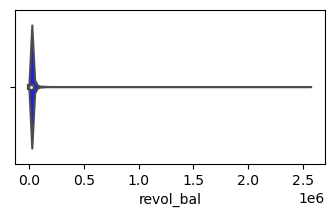

In [34]:
dist('revol_bal')

In [35]:
df_eda['revol_bal_fc'] = pd.cut(df_eda['revol_bal'],9)
woe(df_eda, 'revol_bal_fc')

,revol_bal_fc,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(1712663.333, 1998107.222]",2,0.500000,-19.176933,7.769546
1,"(2283551.111, 2568995.0]",2,1.000000,-19.176933,7.769546
2,"(1141775.556, 1427219.444]",3,0.666667,-18.771466,7.769546
3,"(856331.667, 1141775.556]",4,0.750000,-18.483782,7.769546
4,"(570887.778, 856331.667]",21,0.904762,-16.825517,7.769546
5,"(285443.889, 570887.778]",223,0.883408,-14.462435,7.769546
6,"(-2568.995, 285443.889]",466030,0.883821,0.693209,7.769546
7,"(1427219.444, 1712663.333]",0,NaN,NaN,7.769546
8,"(1998107.222, 2283551.111]",0,NaN,NaN,7.769546


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 1269
Distribution :
count    466285.000000
mean         56.177985
std          23.724005
min           0.000000
25%          39.200000
50%          57.600000
75%          74.700000
max         892.300000
Name: revol_util, dtype: float64


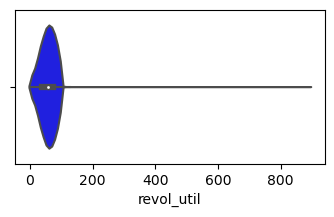

In [36]:
dist('revol_util')

In [37]:
df_eda['revol_util_fc'] = np.where((df_eda['revol_util']>=0)&(df_eda['revol_util']<=20),0,
                                  np.where((df_eda['revol_util']>20)&(df_eda['revol_util']<=40),1,
                                           np.where((df_eda['revol_util']>40)&(df_eda['revol_util']<=60),2,
                                                    np.where((df_eda['revol_util']>60)&(df_eda['revol_util']<=80),3,4))))
woe(df_eda,'revol_util_fc')

,revol_util_fc,num_observation,good_loan_prob,weight_of_evidence,information_value
0,0,37402,0.907438,-1.220141,0.157668
1,1,83492,0.901679,-0.303424,0.157668
2,4,84062,0.859449,-0.295130,0.157668
3,2,129737,0.889114,0.266088,0.157668
4,3,131592,0.876117,0.285812,0.157668


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 112
Distribution :
count    466285.000000
mean         25.064302
std          11.599792
min           1.000000
25%          17.000000
50%          23.000000
75%          32.000000
max         156.000000
Name: total_acc, dtype: float64


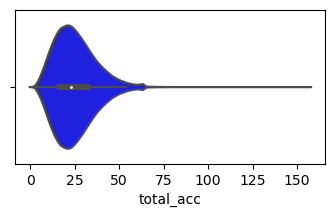

In [38]:
dist('total_acc')

In [39]:
df_eda['total_acc_woe'] = pd.cut(df_eda['total_acc'],9)
woe(df_eda,'total_acc_woe')

,total_acc_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(121.556, 138.778]",1,1.000000,-12.571029,0.471948
1,"(138.778, 156.0]",2,1.000000,-11.877880,0.471948
2,"(104.333, 121.556]",10,1.000000,-10.268425,0.471948
3,"(87.111, 104.333]",67,0.895522,-8.366195,0.471948
4,"(69.889, 87.111]",508,0.901575,-6.339460,0.471948
5,"(52.667, 69.889]",10568,0.889383,-3.282520,0.471948
6,"(35.444, 52.667]",69934,0.892213,-1.253227,0.471948
7,"(0.845, 18.222]",148771,0.872757,-0.276593,0.471948
8,"(18.222, 35.444]",236424,0.887998,0.509673,0.471948


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 135665
Distribution :
count    466285.000000
mean       4410.062342
std        6355.078769
min           0.000000
25%           0.000000
50%         441.470000
75%        7341.650000
max       32160.380000
Name: out_prncp, dtype: float64


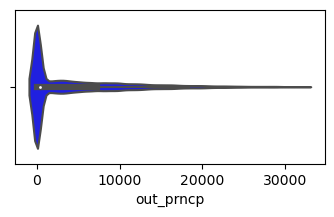

In [40]:
dist('out_prncp')

In [41]:
df_eda['out_prncp_woe'] = pd.cut(df_eda['out_prncp'],9)
woe(df_eda,'out_prncp_woe')

,out_prncp_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(28587.004, 32160.38]",1495,0.904348,-5.422261,1.672141
1,"(25013.629, 28587.004]",3991,0.946880,-4.434961,1.672141
2,"(21440.253, 25013.629]",7259,0.949029,-3.829666,1.672141
3,"(17866.878, 21440.253]",12449,0.952848,-3.278897,1.672141
4,"(14293.502, 17866.878]",19929,0.956947,-2.791743,1.672141
5,"(10720.127, 14293.502]",30179,0.957620,-2.353541,1.672141
6,"(7146.751, 10720.127]",43499,0.960275,-1.956930,1.672141
7,"(3573.376, 7146.751]",55814,0.962590,-1.678082,1.672141
8,"(-32.16, 3573.376]",291670,0.839171,0.830238,1.672141


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 351609
Distribution :
count    466285.000000
mean      11540.686220
std        8265.627112
min           0.000000
25%        5552.125349
50%        9419.250943
75%       15308.158460
max       57777.579870
Name: total_pymnt, dtype: float64


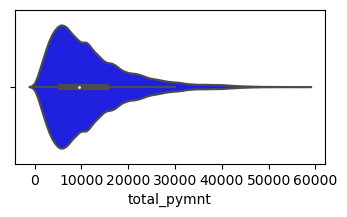

In [42]:
dist('total_pymnt')

In [43]:
df_eda['total_pymnt_woe'] = pd.cut(df_eda['total_pymnt'],10)
woe(df_eda,'total_pymnt_woe')

,total_pymnt_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(51999.822, 57777.58]",84,1.000000,-7.469040,0.462987
1,"(46222.064, 51999.822]",654,0.996942,-5.415527,0.462987
2,"(40444.306, 46222.064]",3176,0.990554,-3.829825,0.462987
3,"(34666.548, 40444.306]",6668,0.983353,-3.080559,0.462987
4,"(28888.79, 34666.548]",11215,0.973963,-2.550684,0.462987
5,"(23111.032, 28888.79]",23277,0.965288,-1.793607,0.462987
6,"(17333.274, 23111.032]",45849,0.952845,-1.063424,0.462987
7,"(11555.516, 17333.274]",90733,0.932439,-0.267961,0.462987
8,"(-57.778, 5777.758]",124655,0.775420,0.144337,0.462987
9,"(5777.758, 11555.516]",159974,0.895958,0.502925,0.462987


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 270249
Distribution :
count    466285.000000
mean       2588.677225
std        2483.809661
min           0.000000
25%         957.280000
50%        1818.880000
75%        3304.530000
max       24205.620000
Name: total_rec_int, dtype: float64


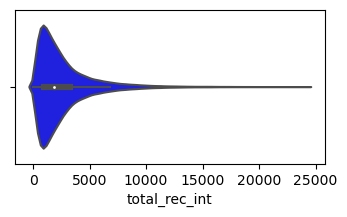

In [44]:
dist('total_rec_int')

In [45]:
df_eda['total_rec_int_woe'] = pd.cut(df_eda['total_rec_int'],15)
woe(df_eda,'total_rec_int_woe')

,total_rec_int_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(22591.912, 24205.62]",13,1.000000,-9.673832,0.780801
1,"(20978.204, 22591.912]",58,0.913793,-8.178242,0.780801
2,"(19364.496, 20978.204]",134,0.895522,-7.340682,0.780801
3,"(17750.788, 19364.496]",294,0.887755,-6.554598,0.780801
4,"(16137.08, 17750.788]",588,0.920068,-5.860820,0.780801
5,"(14523.372, 16137.08]",1005,0.911443,-5.323908,0.780801
6,"(12909.664, 14523.372]",1423,0.886156,-4.975230,0.780801
7,"(11295.956, 12909.664]",2630,0.908745,-4.358414,0.780801
8,"(9682.248, 11295.956]",4902,0.898613,-3.730842,0.780801
9,"(8068.54, 9682.248]",8969,0.893968,-3.117857,0.780801


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 5808
Distribution :
count    466285.000000
mean          0.650129
std           5.265730
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         358.680000
Name: total_rec_late_fee, dtype: float64


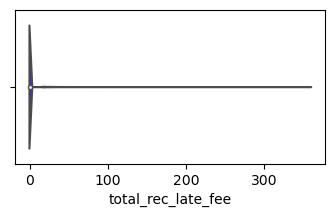

In [46]:
dist('total_rec_late_fee')

In [47]:
df_eda['total_rec_late_fee_woe'] = pd.cut(df_eda['total_rec_late_fee'],10)
woe(df_eda,'total_rec_late_fee_woe')

,total_rec_late_fee_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(286.944, 322.812]",1,0.000000,-17.664310,5.618606
1,"(322.812, 358.68]",1,0.000000,-17.664310,5.618606
2,"(215.208, 251.076]",2,0.500000,-16.971161,5.618606
3,"(251.076, 286.944]",3,0.666667,-16.565693,5.618606
4,"(179.34, 215.208]",8,0.375000,-15.584853,5.618606
5,"(143.472, 179.34]",19,0.421053,-14.719832,5.618606
6,"(107.604, 143.472]",85,0.435294,-13.221479,5.618606
7,"(71.736, 107.604]",279,0.433692,-12.032502,5.618606
8,"(35.868, 71.736]",1905,0.447244,-10.107981,5.618606
9,"(-0.359, 35.868]",463982,0.885998,0.693873,5.618606


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 22773
Distribution :
count    466285.000000
mean         85.344211
std         552.216084
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       33520.270000
Name: recoveries, dtype: float64


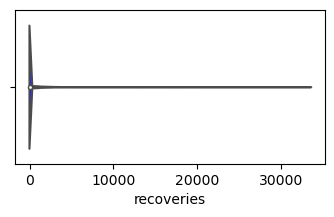

In [48]:
dist('recoveries')

In [49]:
df_eda['recoveries_woe'] = pd.cut(df_eda['recoveries'],10)
woe(df_eda,'recoveries_woe')

,recoveries_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(30168.243, 33520.27]",2,0.000000,-16.691282,5.288953
1,"(23464.189, 26816.216]",3,0.000000,-16.285814,5.288953
2,"(26816.216, 30168.243]",3,0.000000,-16.285814,5.288953
3,"(20112.162, 23464.189]",10,0.000000,-15.081827,5.288953
4,"(16760.135, 20112.162]",13,0.000000,-14.819456,5.288953
5,"(13408.108, 16760.135]",32,0.000000,-13.918629,5.288953
6,"(10056.081, 13408.108]",74,0.000000,-13.080209,5.288953
7,"(6704.054, 10056.081]",241,0.000000,-11.899119,5.288953
8,"(3352.027, 6704.054]",2664,0.000000,-9.491119,5.288953
9,"(-33.52, 3352.027]",463243,0.889622,0.693856,5.288953


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 198194
Distribution :
count    466285.000000
mean       3123.913796
std        5554.737393
min           0.000000
25%         312.620000
50%         545.960000
75%        3187.510000
max       36234.440000
Name: last_pymnt_amnt, dtype: float64


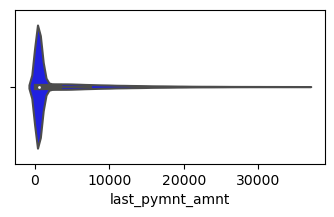

In [50]:
dist('last_pymnt_amnt')

In [51]:
df_eda['last_pymnt_amnt_fc'] = np.where((df_eda['last_pymnt_amnt']>=0)&(df_eda['last_pymnt_amnt']<=500),0,
                               np.where((df_eda['last_pymnt_amnt']>500)&(df_eda['last_pymnt_amnt']<=1000),1,
                               np.where((df_eda['last_pymnt_amnt']>1000)&(df_eda['last_pymnt_amnt']<=1500),2,
                                        np.where((df_eda['last_pymnt_amnt']>1500)&(df_eda['last_pymnt_amnt']<=3500),3,4))))
woe(df_eda,'last_pymnt_amnt_fc')

,last_pymnt_amnt_fc,num_observation,good_loan_prob,weight_of_evidence,information_value
0,2,14979,0.871821,-2.659133,0.526734
1,3,23745,0.974395,-2.178796,0.526734
2,1,98694,0.843476,-0.568584,0.526734
3,4,112856,0.995383,-0.395207,0.526734
4,0,216011,0.834837,0.599136,0.526734


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 9
Distribution :
count    466285.000000
mean          0.009082
std           0.108632
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: collections_12_mths_ex_med, dtype: float64


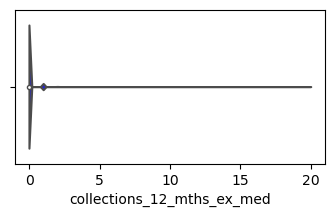

In [52]:
dist('collections_12_mths_ex_med')

In [53]:
df_eda['collections_12_mths_ex_med_woe'] = pd.cut(df_eda['collections_12_mths_ex_med'],4)
woe(df_eda,'collections_12_mths_ex_med_woe')

,collections_12_mths_ex_med_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(5.0, 10.0]",1,1.000000,-24.313335,12.27221
1,"(15.0, 20.0]",2,1.000000,-23.620186,12.27221
2,"(-0.02, 5.0]",466282,0.883817,0.693149,12.27221
3,"(10.0, 15.0]",0,NaN,NaN,12.27221


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 6
Distribution :
count    466285.000000
mean          0.004002
std           0.068635
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.000000
Name: acc_now_delinq, dtype: float64


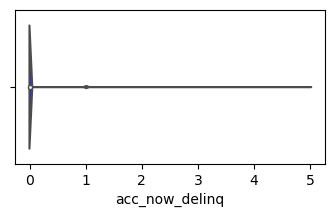

In [54]:
dist('acc_now_delinq')

In [55]:
df_eda['acc_now_delinq_woe'] = pd.cut(df_eda['acc_now_delinq'],3)
woe(df_eda,'acc_now_delinq_woe')

,acc_now_delinq_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(3.333, 5.0]",6,0.833333,-18.928591,8.467657
1,"(1.667, 3.333]",103,0.893204,-16.085414,8.467657
2,"(-0.005, 1.667]",466176,0.883816,0.693159,8.467657


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 6321
Distribution :
count    4.662850e+05
mean     1.629893e+02
std      1.348289e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64


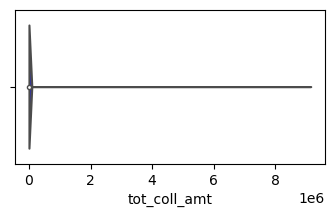

In [56]:
dist('tot_coll_amt')

C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 220690
Distribution :
count    4.662850e+05
mean     1.178823e+05
std      1.487196e+05
min      0.000000e+00
25%      1.546700e+04
50%      5.247900e+04
75%      1.849300e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64


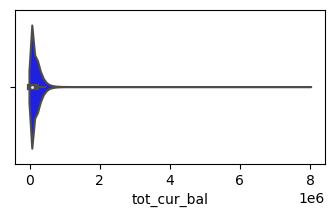

In [57]:
dist('tot_cur_bal')

In [58]:
df_eda['tot_cur_bal_woe'] = pd.cut(df_eda['tot_cur_bal'],5)
woe(df_eda,'tot_cur_bal_woe')

,tot_cur_bal_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(6400062.4, 8000078.0]",1,1.000000,-20.624183,8.44193
1,"(3200031.2, 4800046.8]",11,0.909091,-18.226266,8.44193
2,"(1600015.6, 3200031.2]",108,0.935185,-15.941822,8.44193
3,"(-8000.078, 1600015.6]",466165,0.883805,0.693170,8.44193
4,"(4800046.8, 6400062.4]",0,NaN,NaN,8.44193


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


number of unique values : 14612
Distribution :
count    4.662850e+05
mean     2.580051e+04
std      3.600534e+04
min      0.000000e+00
25%      8.900000e+03
50%      1.920000e+04
75%      3.430000e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64


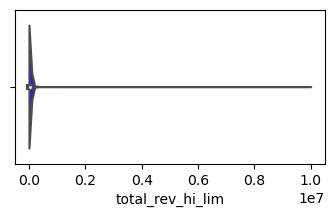

In [59]:
dist('total_rev_hi_lim')

In [60]:
df_eda['total_rev_hi_lim_woe'] = pd.cut(df_eda['total_rev_hi_lim'],5)
woe(df_eda,'total_rev_hi_lim_woe')

,total_rev_hi_lim_woe,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(1999999.8, 3999999.6]",1,1.000000,-24.313335,12.27221
1,"(7999999.2, 9999999.0]",2,1.000000,-23.620186,12.27221
2,"(-9999.999, 1999999.8]",466282,0.883817,0.693149,12.27221
3,"(3999999.6, 5999999.4]",0,NaN,NaN,12.27221
4,"(5999999.4, 7999999.2]",0,NaN,NaN,12.27221


##### Fitur akan dihapus karena memiliki:

- Nilai informasi <0.02 (tidak bermanfaat untuk prediksi)
- Nilai informasi > 0.5 (prediktif yang mencurigakan)
- Fitur yang tidak masuk akal untuk dibinariesasi

In [61]:
drop_list = ['verification_status',
             'delinq_2yrs',
             'inq_last_6mths',
             'pub_rec',
             'out_prncp',
             'total_rec_int',
             'total_rec_late_fee',
             'recoveries',
             'collections_12_mths_ex_med',
             'acc_now_delinq',
             'tot_coll_amt',
             'tot_cur_bal',
             'total_rev_hi_lim']

In [62]:
df_cleaned = df_cleaned.drop(drop_list, axis=1)

In [63]:
df_cleaned.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,loan_status,pymnt_plan,purpose,dti,open_acc,revol_bal,revol_util,total_acc,initial_list_status,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,collection_recovery_fee,last_pymnt_amnt,pymnt_time,credit_pull_year,annual_inc_fc
0,1077501,5000,5000,4975.0,36 months,10.65,162.87,B,10,RENT,24000.0,1,n,credit_card,27.65,3.0,13648,83.7,9.0,f,0.0,5861.071414,5831.78,5000.00,0.00,171.62,13,31,low_income
1,1077430,2500,2500,2500.0,60 months,15.27,59.83,C,0,RENT,30000.0,0,n,car,1.00,3.0,1687,9.4,4.0,f,0.0,1008.710000,1008.71,456.46,1.11,119.66,34,14,low_income
2,1077175,2400,2400,2400.0,36 months,15.96,84.33,C,10,RENT,12252.0,1,n,small_business,8.72,2.0,2956,98.5,10.0,f,0.0,3003.653644,3003.65,2400.00,0.00,649.91,20,15,low_income
3,1076863,10000,10000,10000.0,36 months,13.49,339.31,C,10,RENT,49200.0,1,n,other,20.00,10.0,5598,21.0,37.0,f,0.0,12226.302210,12226.30,10000.00,0.00,357.48,13,19,low_income
4,1075358,3000,3000,3000.0,60 months,12.69,67.79,B,1,RENT,80000.0,1,n,other,17.94,15.0,27783,53.9,38.0,f,766.9,3242.170000,3242.17,2233.10,0.00,67.79,1,20,low_income


In [64]:
path_file = 'data/loan_cleaned_v1.csv'
df_cleaned.to_csv(path_file, index=False)